In [52]:
from keras.models import load_model
from numpy import load
from numpy import expand_dims
from numpy import load
import tensorflow as tf
import os

from os.path import join
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from numpy import savez_compressed

import cv2
import math
import numpy as np
import skimage.measure as skm
from skimage.metrics import structural_similarity as ssim



In [51]:
modelo_prueba = load_model('model_pix2pix_norma_461370.h5', compile=False)

In [3]:
modelo_prueba.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 256, 256, 64)         1088      ['input_3[0][0]']             
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)   (None, 256, 256, 64)         0         ['conv2d_6[0][0]']            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 128, 128, 128)        131200    ['leaky_re_lu_5[0][0]']       
                                                                                            

In [28]:
# path = r'C:\Users\varodri\Documents\repositorios\vsce-prueba-vale\src\vsce_prueba_vale\experimentales'
path = r'/content/vali'

file_list = os.listdir(path)

In [29]:
tom1_real_files = sorted([file for file in file_list if file.startswith('tom1_real')])
tom1_imag_files = sorted([file for file in file_list if file.startswith('tom1_imag')])
tom1_data = {}

for filename_tom1_real, filename_tom1_imag in zip(tom1_real_files, tom1_imag_files):
    z, x, y = [int(re.search(f'{dim}=([0-9]+)', filename_tom1_real).group(1)) for dim in ['z', 'x', 'y']]

    tom1_real = np.fromfile(join(path, filename_tom1_real), 'single').reshape((z, x, y), order='F')
    tom1_imag = np.fromfile(join(path, filename_tom1_imag), 'single').reshape((z, x, y), order='F')

    tom1 = tom1_real + 1j * tom1_imag
    del tom1_real, tom1_imag
    filename_tom1 = filename_tom1_real.replace('_real', '')

    tom1_data[filename_tom1] = tom1
#%%
solapValues = []
solap = 20
maxSolap = z * 0.6

while solap <= maxSolap:
    solapValues.append(solap)
    solap = int(solap * 3.4)

solapValues = [int(value) for value in solapValues]
#%%
inputs_original = []
targets_original = []
vali = []
real = []

for filename, tom1 in tom1_data.items():
    for solap in solapValues:
        z, x, y = tom1.shape  # Obtiene la forma de tom1
        newTom = np.zeros((2*z,x,y),dtype=complex)
        newTom2 = np.zeros((2*z,x,y),dtype=complex)

        newTom[solap:512+solap,:,:] = tom1 #solapado
        newTom2[solap:512+solap,:,:] = tom1 #desplazdo

        newTom[512-solap:1024-solap,:,:] = newTom[512-solap:1024-solap,:,:] + np.flip(tom1,axis=0)
        newTom2[512-solap:1024-solap,:,:] = newTom2[512-solap:1024-solap,:,:]

        center = newTom2.shape[0] // 2
        newTom2_cut = newTom2[center-256:center+256,:,:]

        center = newTom.shape[0] // 2
        newTom_cut = newTom[center-256:center+256,:,:]
        const = 0.0000001  # Una peque a constante

        for i in range(newTom_cut.shape[2]):
            inputs_original.append(newTom_cut[:,:,i])
            inputs_original.append(newTom2_cut[:,:,i])

            transformed_input = 20 * np.log10(np.abs(newTom_cut[:,:,i]) + const)
            transformed_target = 20 * np.log10(np.abs(newTom2_cut[:,:,i]) + const)
            vali.append(transformed_input)
            real.append(transformed_target)

vali_set = np.expand_dims(np.array(vali, dtype='float32'), -1)
real_set = np.expand_dims(np.array(real, dtype='float32'), -1)

# print(inputs_amplitud.shape)
# filename = 'dataset_intensidad.npz'
# savez_compressed(filename, inputs_amplitud, targets_amplitud)
# print('Dataset guardado como:', filename)


In [30]:
filename = 'dataset_validacion.npz'
savez_compressed(filename, vali_set)

In [31]:
print(vali_set.shape)

(24, 512, 512, 1)


In [32]:
filename = 'dataset_real.npz'
savez_compressed(filename, real_set)

In [33]:
print(vali_set.shape)

(24, 512, 512, 1)


In [10]:
def load_real_samples(filename):
 data = load(filename)
 y1 = data['arr_0']
 y1 = (y1 - 127.5) / 127.5
 return [y1]

In [34]:
dataset_vali = load_real_samples('dataset_validacion.npz')

In [35]:
set_real =  load_real_samples('dataset_real.npz')

In [36]:
y_t = set_real[0]
print(y_t.shape)

(24, 512, 512, 1)


In [37]:
#prediccion
val = dataset_vali[0]
print(val.shape)

(24, 512, 512, 1)


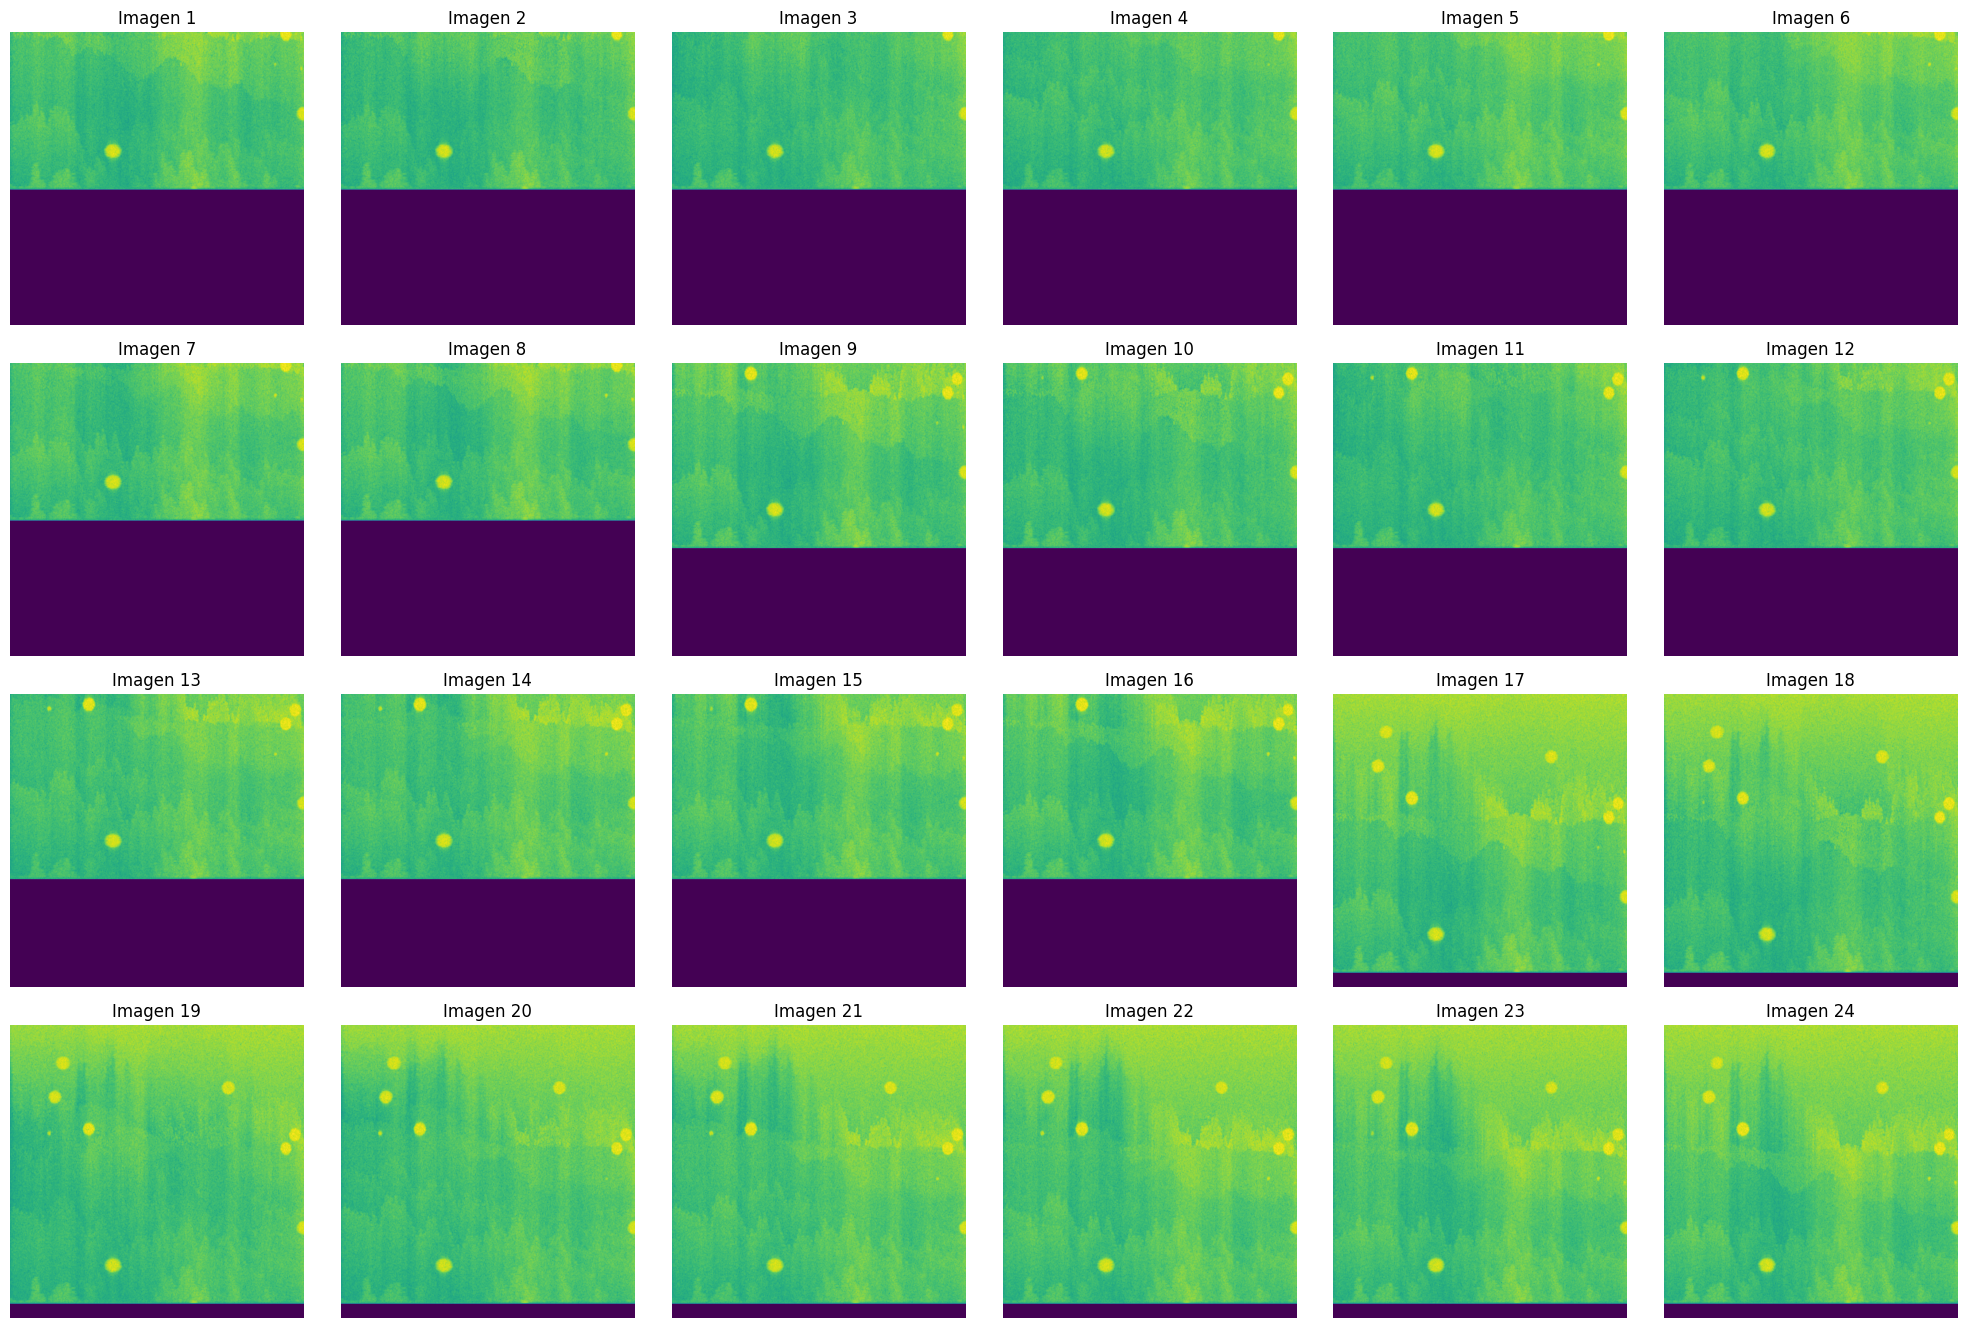

In [39]:

# Asumiendo que `val` es tu conjunto de datos de validación y tiene la forma (32, 512, 512, 1)
num_images = y_t.shape[0]  # Número de imágenes

# Configurar el tamaño de la figura para que sea lo suficientemente grande
plt.figure(figsize=(20, 20))

# Graficar cada imagen
for i in range(num_images):
    plt.subplot(6, 6, i + 1)  # Ajusta el número de filas y columnas según necesites
    plt.imshow(np.squeeze(y_t[i]))  # np.squeeze para remover la dimensión de canal si es 1
    plt.title(f'Imagen {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

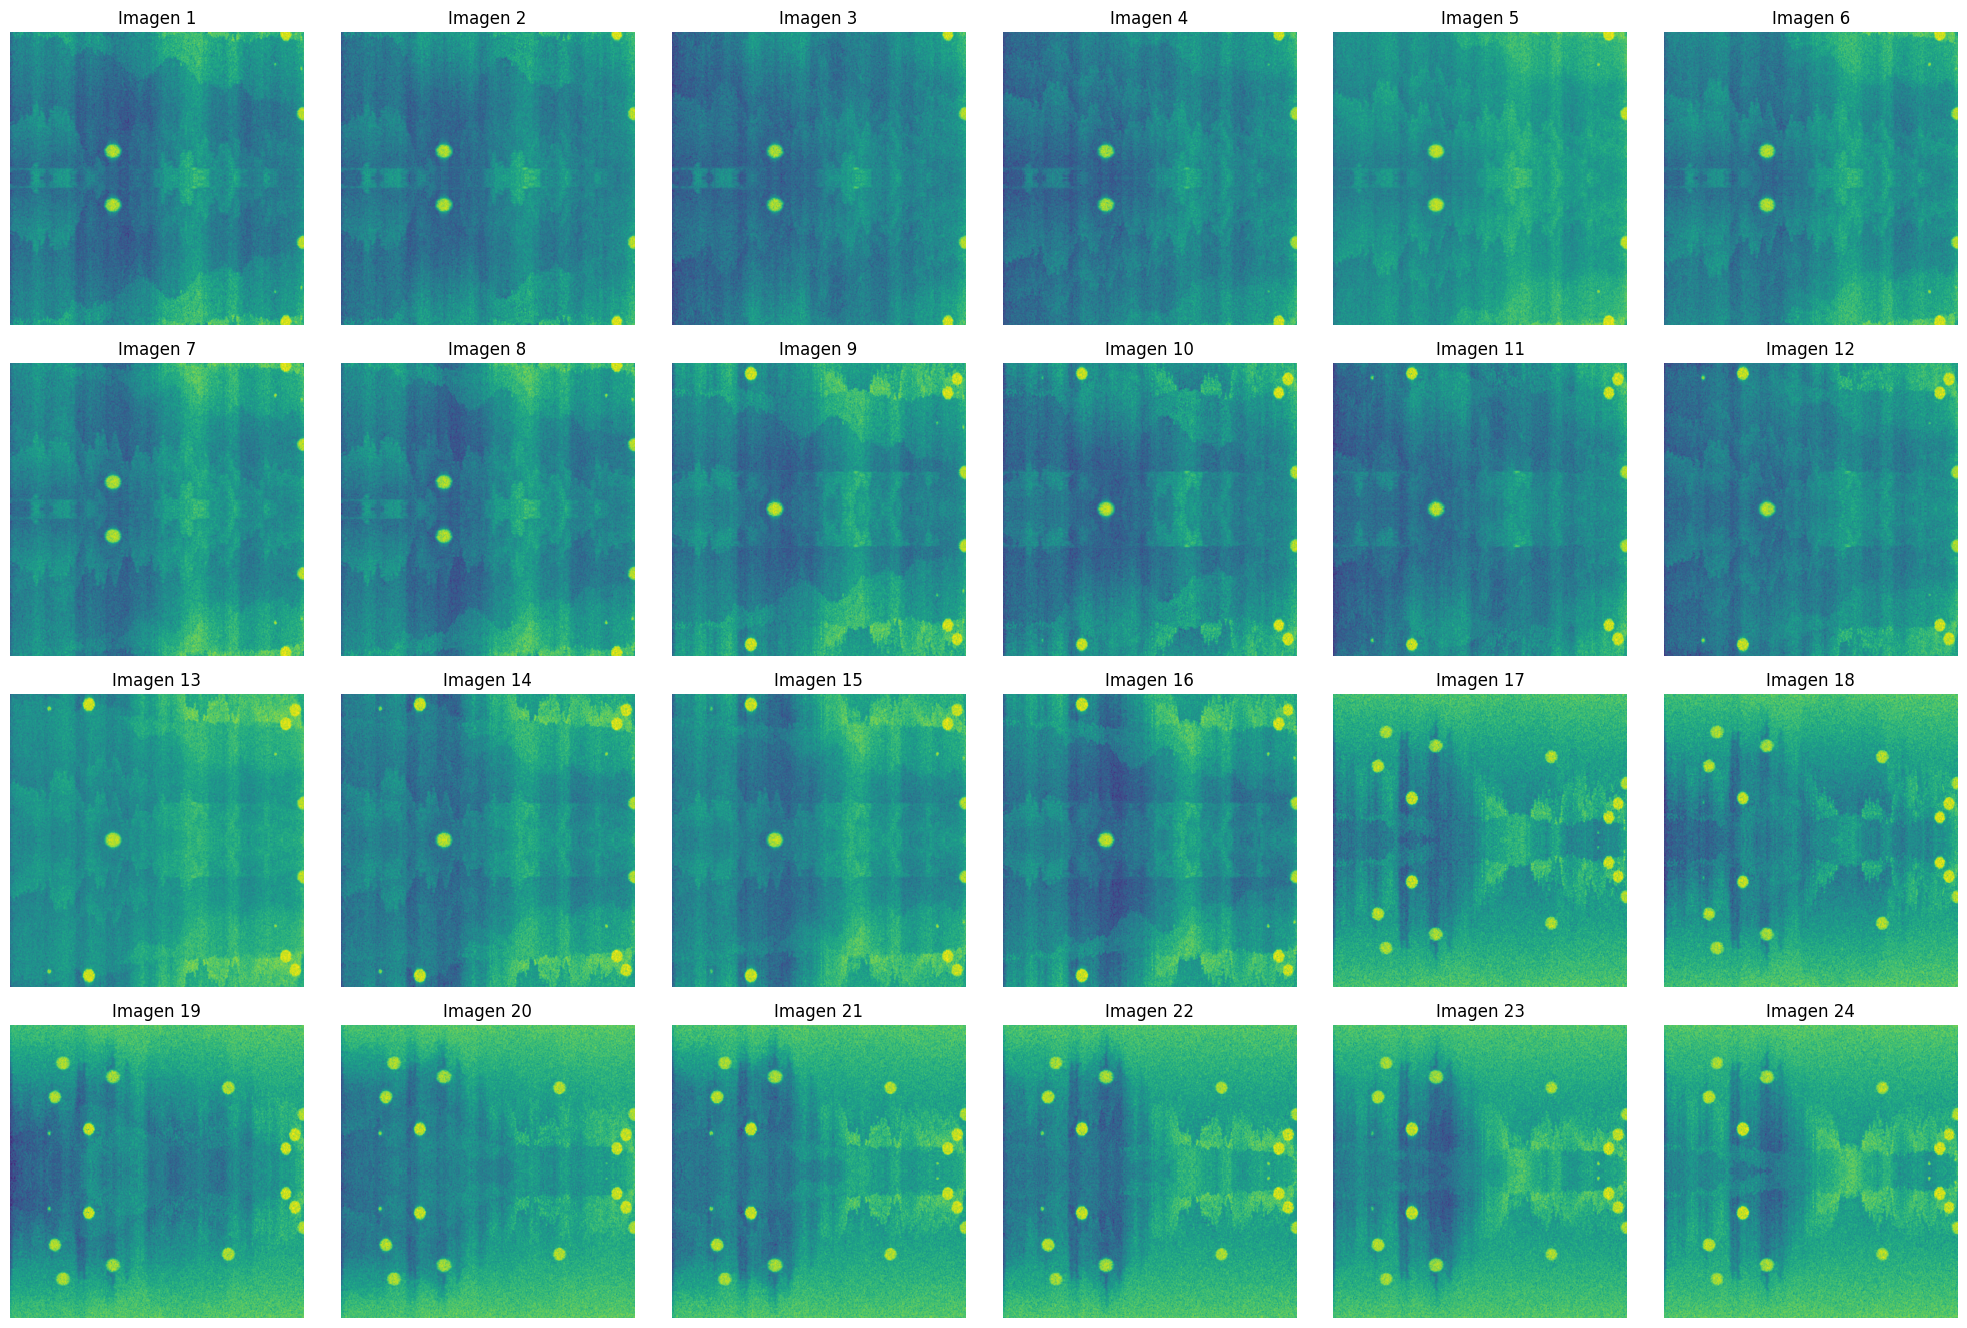

In [40]:


# Asumiendo que `val` es tu conjunto de datos de validación y tiene la forma (32, 512, 512, 1)
num_images = val.shape[0]  # Número de imágenes

# Configurar el tamaño de la figura para que sea lo suficientemente grande
plt.figure(figsize=(20, 20))

# Graficar cada imagen
for i in range(num_images):
    plt.subplot(6, 6, i + 1)  # Ajusta el número de filas y columnas según necesites
    plt.imshow(np.squeeze(val[i]))  # np.squeeze para remover la dimensión de canal si es 1
    plt.title(f'Imagen {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [42]:
predictions = modelo_prueba.predict(val)

1/1 [==============================] - 32s 32s/step


<Figure size 1000x600 with 0 Axes>

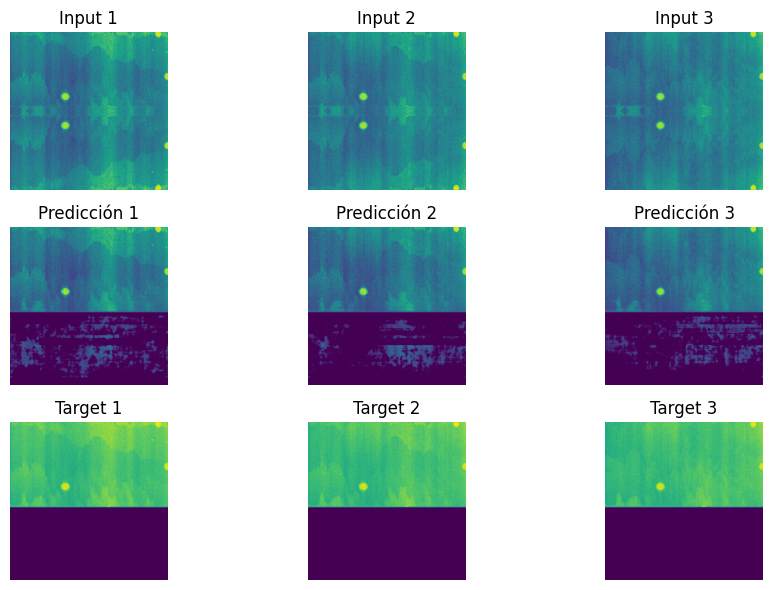

In [44]:
# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))


plt.figure(figsize=(10, 6))

for i in range(3):
    # Graficar la imagen de entrada
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(val[i]))
    plt.title(f'Input {i+1}')
    plt.axis('off')

    # Graficar la predicción
    plt.subplot(3, 3, i + 4)
    plt.imshow(np.squeeze(predictions[i]))
    plt.title(f'Predicción {i+1}')
    plt.axis('off')

    # Graficar el objetivo/target
    plt.subplot(3, 3, i + 7)
    plt.imshow(np.squeeze(y_t[i]))
    plt.title(f'Target {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [53]:
 # metricas produc punto

# def psnr(original, reconstructed):

#   """Calcula la Relación Señal-Ruido de Pico
#    (PSNR) entre dos imágenes"""

#   mse = cv2.meanSquaredError(original, reconstructed)
#   if mse == 0:
#     return float('Inf')
#   return 20 * math.log10(255.0 / math.sqrt(mse))
def psnr(original, reconstructed):
    """Calcula la Relación Señal-Ruido de Pico (PSNR) entre dos imágenes"""
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr_value = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr_value

def mae(original, reconstructed):
  """Calcula (MAE) entre dos imágenes"""
  mae_value = np.mean(np.abs(original - reconstructed))
  return mae_value

def ssim(original, reconstructed):
  """Calcula Índice de similitud estructural (SSIM) entre dos imágenes"""
  ssim_value, _ = skm.compare_ssim(original, reconstructed, full=True)
  return ssim_value

In [55]:
from skimage.metrics import structural_similarity as ssim

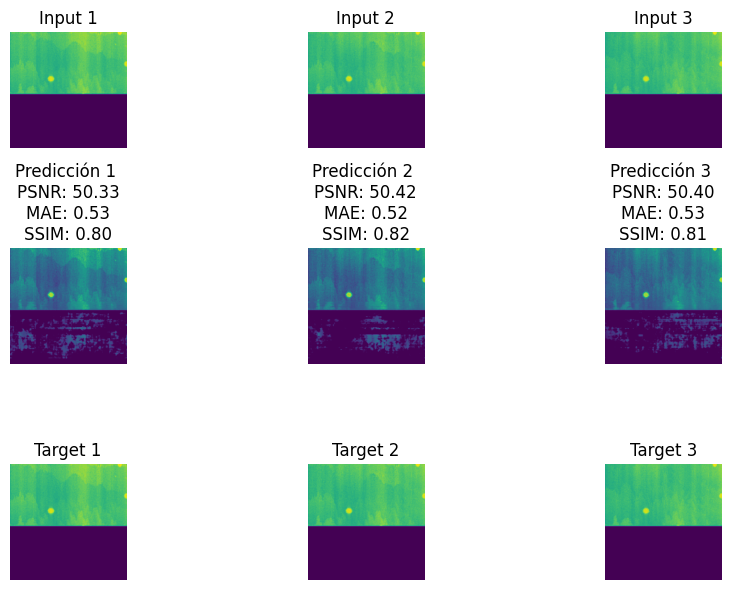

In [56]:
plt.figure(figsize=(10, 6))

for i in range(3):
    original = np.squeeze(y_t[i])
    reconstructed = np.squeeze(predictions[i])

    # Calcular métricas
    psnr_value = psnr(original, reconstructed)
    mae_value = mae(original, reconstructed)
    ssim_value = ssim(original, reconstructed)

    # Graficar la imagen de entrada
    plt.subplot(3, 3, i + 1)
    plt.imshow(original)
    plt.title(f'Input {i+1}')
    plt.axis('off')

    # Graficar la predicción
    plt.subplot(3, 3, i + 4)
    plt.imshow(reconstructed)
    plt.title(f'Predicción {i+1} \nPSNR: {psnr_value:.2f}\nMAE: {mae_value:.2f}\nSSIM: {ssim_value:.2f}')
    plt.axis('off')

    # Graficar el objetivo/target
    target = np.squeeze(y_t[i])
    plt.subplot(3, 3, i + 7)
    plt.imshow(target)
    plt.title(f'Target {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()